<a href="https://colab.research.google.com/github/bensapirstein/DeepGraphemics/blob/main/4_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
if 'google.colab' in sys.modules:
    import gdown
    if 'torch' not in sys.modules:
        !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    if 'skia-python' not in sys.modules:
        !pip3 install skia-python

    if os.getcwd() != '/content/DeepGraphemics':
        !git clone https://github.com/bensapirstein/DeepGraphemics.git
        %cd DeepGraphemics/

    url = 'https://drive.google.com/drive/folders/1X3ERUGyhMZo_ZlHApI1XkjcZAVcnTRNd?usp=drive_link'

    gdown.download_folder(url)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# unzip several databases based on category and letter.

categories = ["base", "moderate", "rotation", "rich_moderate", "rich_rotation"]

for ds_type in categories:
    root_dir = f"datasets/{ds_type}_dataset"
    if not os.path.exists(root_dir):
        zipped_data = f"{root_dir}.zip"
        !unzip -q $zipped_data -d datasets/

our experiments include:

train VAE with latent space dimension 2, 3, 5, 10, 20

train with different hidden layer sizes. (optional)

train VAE on different datasets: "base", "moderate", "rotation" and rich datasets.

train on different letters.

train capsnet with different reconstruction loss weights: 0.0005, 0.005, 0.01, 1, 100

train capsnet with different datasets: "base", "moderate", "rotation" and rich datasets.

In [ ]:
# example run of an experiment

from src.experiments import load_experiment, run_experiment
from src.plot import plot_fit
from configs.config import capsnet_config, vae_config
seed = 42

model_type = 'vae'

# model params kwargs
params = vae_config

run_name = f'{model_type}_test_run'
ds_type = 'base'
data_dir = f'datasets/{ds_type}_dataset/'
epochs = 10

# Test experiment implementation on a few data samples and with a small model
run_experiment(
    run_name, data_dir, letter="aleph", seed=seed,
    bs_train=128, bs_test=128, epochs=epochs, early_stopping=5,
    model_type=model_type, model_config=params
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment(f'results/{run_name}.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

In [ ]:
import itertools
from configs.config import dotdict

# hyperparameter search
latent_dims = [2, 3, 5]
capacity = [64]
variational_beta = [1.0]
letters = ["aleph", "shin", "qoph"]
ds_types = ["base", "moderate", "rotation"]
n_epochs = 100

for letter, ds_type, latent_dim, cap, beta in itertools.product(letters, ds_types, latent_dims, capacity, variational_beta):
    vae_config = dotdict({
        'latent_dims': latent_dim,
        'capacity': cap,
        'variational_beta': beta
    })

    data_dir = f'datasets/{ds_type}_dataset/'

    run_name = f"vae_{ds_type}_{letter}_{latent_dim}_{cap}_{beta}"
    print(f"Running {letter} experiment on {ds_type} dataset with latent_dim={latent_dim}, capacity={cap}, beta={beta}")
    fit_res = run_experiment(run_name, data_dir, epochs=n_epochs, letter=letter, model_type=model_type, model_config=vae_config, save_model=True)


In [35]:
from src.experiments import load_experiment
from src.plot import plot_fit, plot_loss

import sys
import os
import glob
import re

def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        if "rotation" in filepath or "moderate" in filepath:
            m = re.match('vae_*_(.*)\.json', os.path.basename(filepath))
            cfg, fit_res = load_experiment(filepath)
            fig, axes = plot_loss(fit_res, fig, legend=m[1],log_loss=True)
    print('common config: ', cfg)

common config:  {'run_name': 'vae_rotation_aleph_5_64_1.0', 'data_dir': 'datasets/rotation_dataset/', 'letter': 'aleph', 'out_dir': './results', 'seed': 1106632155, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 1e-05, 'model_type': 'vae', 'model_config': {'latent_dims': 5, 'capacity': 64, 'variational_beta': 1.0}, 'save_model': True, 'kw': {}}


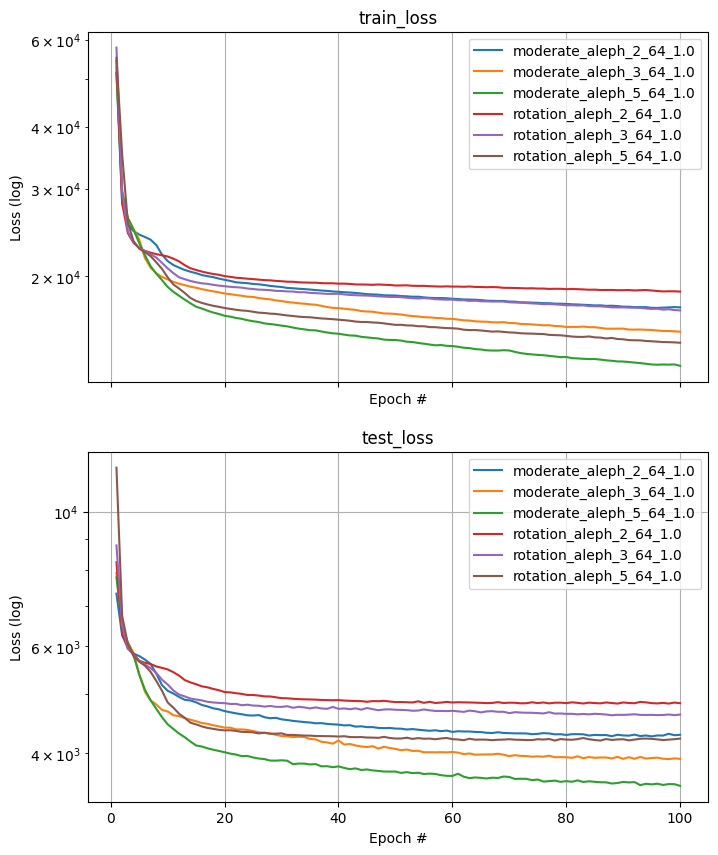

In [36]:
plot_exp_results("vae_*_aleph_*.json", "results/experiment 2")